In [ ]:
# Required upgrade for RCF fix
! pip install --upgrade sagemaker==1.42.8

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

from sklearn.decomposition import PCA


In [2]:
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 100



In [3]:
bucket = 'leaseplan-oct-2019-ml-immersion'
prefix = 'lease-plan'
filename = 'sample_data.csv'
s3_fullpath = os.path.join('s3://', bucket, prefix, 'raw-data', filename)

!aws s3 cp $s3_fullpath .

download: s3://leaseplan-oct-2019-ml-immersion/lease-plan/raw-data/sample_data.csv to ./sample_data.csv


In [4]:
# Read from S3 or local
raw_data = pd.read_csv(filename, header=0, sep=',')


########################
# Drop list of iobjectid that has corrupted data
########################
iobjectid = [161541]
raw_data = raw_data[~raw_data['iobjectid'].isin(iobjectid)]
raw_data.reset_index(inplace=True)
print(raw_data.shape)

(62, 30)


## Helper functions

In [5]:
import os
import io
import boto3



def get_col_with_null(df):
    series = raw_data.isnull().sum()
    null_col = series[series != 0].index
    
    return list(null_col)



def data_transformation(df):
    
    raw_data = df.copy()
    print(f'Initial data shape: {raw_data.shape}')
    

    # replace null col with 0
    col_with_null = get_col_with_null(raw_data)
    raw_data[col_with_null] = raw_data[col_with_null].fillna(0) 
    
    num_features = raw_data.select_dtypes(exclude='object').columns
    cat_features = raw_data.select_dtypes(include='object').columns

    assert(len(cat_features)+len(num_features) == len(raw_data.columns))
    
    # Column to be dropped
    drop_columns = ['serviceorderid', # grouping info has been implicited used during feature engineering
                    'iobjectid', # does not tell much info, drop for now
                    'customertopnode', # highly corrected to iobjectid
                    'serviceinterval', # highly Correlated to serviceorderid 
                    'terminationflag', #single value: "#"
                     'terminationtype', #single value: "not assigned"
                     'vehicledesc', # text is ignored for now, embedding can be done
                     'accountingindicator', #single value: "budget"
                    ]
    
    
    ########################
    # Feature engineering
    ########################
    # Take 1st 2-digits of post code
    raw_data['supplierpostcode'] = raw_data['supplierpostcode'].apply(lambda x: int(x / 100))
        
    # Check that by grouping 'serviceorderid', the total cost is equal to 'totalcostbyserviceorder'
    raw_data_gb = raw_data.groupby('serviceorderid')['costexcgst']

    total_cost_df = pd.DataFrame(raw_data_gb.sum())
    total_cost_df.columns = ['totalcost_check']

    raw_data = raw_data.merge(total_cost_df, on='serviceorderid')
    raw_data['unmatched_total'] = np.where((raw_data['totalcostbyserviceorder'] - raw_data['totalcost_check']).astype(int) != 0, 1, 0)
    raw_data['cost_ratio'] = raw_data['costexcgst'] / raw_data['totalcostbyserviceorder']

    # Extract numerical quantity without unit
    raw_data['quantity'] = raw_data['quantity'].str.extract('(\d+)')
    raw_data['quantity'] = raw_data['quantity'].fillna(1)

    # treat these as categorical instead of numerical, 
    num_to_cat_col = ['supplierpostcode','industry_code']
    cat_to_num_col = ['quantity']
    

    # update date column to datetime types
    raw_data['jobdate'] = pd.to_datetime(raw_data['jobdate'])
    raw_data['contractstartdateorig'] = pd.to_datetime(raw_data['contractstartdateorig'])
    raw_data['contractenddate'] = pd.to_datetime(raw_data['contractenddate'])
    raw_data['lastknownododate'] = pd.to_datetime(raw_data['lastknownododate'])
    raw_data['builddate'] = pd.to_datetime(raw_data['builddate'])

    date_col = list(raw_data.select_dtypes('datetime64').columns)
    print(f'Date col: {date_col}\n')
    
    # Contract duration
    duration_day = raw_data['contractenddate'] - raw_data['contractstartdateorig']
    raw_data['contract_duration_days'] = duration_day.map(lambda x: x.days)   
    
    # Car ages
    car_age_days = pd.datetime.now() - raw_data['builddate']
    raw_data['car_age_days'] = car_age_days.map(lambda x: x.days)


    ########################
    # New feature to be added
    ########################
    new_num_col = ['contract_duration_days','car_age_days','cost_ratio']
    new_cat_col = ['unmatched_total']
    
    
    ########################
    # Columnn name tracking
    ########################
    final_num_features = list(set(num_features) - set(num_to_cat_col) - set(drop_columns))
    final_num_features = final_num_features + new_num_col + cat_to_num_col
    print(f'Num features: {final_num_features}\n')

    final_cat_features = list(set(cat_features) - set(date_col) - set(cat_to_num_col) - set(drop_columns))
    final_cat_features = final_cat_features + new_cat_col + num_to_cat_col
    print(f'Catogorial features: {final_cat_features}\n')

    raw_data[final_cat_features] = raw_data[final_cat_features].apply(lambda x: x.astype('category'))
    raw_data[final_num_features] = raw_data[final_num_features].apply(lambda x: x.astype('float'))

    data = raw_data[final_num_features+final_cat_features]
    
    ########################
    # Onehot for categorical column
    ########################
    data = pd.get_dummies(data, prefix_sep='_', drop_first=True)
    data = data.astype('float')

    
    ########################
    # Standardization
    ########################
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    
    pca = PCA(n_components=2)
    pca_df = pd.DataFrame(pca.fit_transform(data_scaled), columns=['pca1','pca2'])  
    data_scaled = pd.concat([data_scaled, pca_df], axis=1)

    print(f'New data shape: {data_scaled.shape}')


    return data_scaled


def plot_anomaly(df):
    """Plot pca1/pca2 column with anomaly colormap"""
    
    temp = df.sort_values(['anomaly'], ascending=True)

    fig, ax = plt.subplots(figsize=(10,5))

    cm = {0:'green', 1:'red'}
    ax.scatter(x=temp['pca1'], y=temp['pca2'], c=temp['anomaly'].apply(lambda x: cm[x]))
    plt.show()

def save_s3_file_csv(bucket, file_data, dataset, header=None, index=None):
    csv_buffer = io.StringIO()
    dataset.to_csv(csv_buffer, header=header, index=index)
    s3_client = boto3.client('s3')
    response = s3_client.put_object(Bucket=bucket, Key=file_data, Body=csv_buffer.getvalue())
    return response


    

## Data Transformation


In [6]:
new_data = data_transformation(raw_data)
new_data.head()

Initial data shape: (62, 30)
Date col: ['jobdate', 'contractstartdateorig', 'contractenddate', 'lastknownododate', 'builddate']

Num features: ['labourcost', 'odometer', 'supplier_srt', 'totalcostbyserviceorder', 'partscost', 'index', 'costexcgst', 'contract_duration_days', 'car_age_days', 'cost_ratio', 'quantity']

Catogorial features: ['make', 'industry_desc', 'contractserviceitem', 'bodytype', 'productshorttext', 'servicetype', 'model', 'unmatched_total', 'supplierpostcode', 'industry_code']

New data shape: (62, 46)


,labourcost,odometer,supplier_srt,totalcostbyserviceorder,partscost,index,costexcgst,contract_duration_days,car_age_days,cost_ratio,quantity,make_Toyota,industry_desc_Services: Social Services,industry_desc_Transport and Communications: Electricit,contractserviceitem_Misc Operating Costs Budget,contractserviceitem_Service Plan,bodytype_Station Wagon,bodytype_Van,productshorttext_DIFF OIL,productshorttext_ENGINE OIL,productshorttext_ENVIRONMENTAL LEVY,productshorttext_FUEL FILTER,productshorttext_GEAR OIL,productshorttext_GLOBE - BRAKE LIGHT RIGHT,productshorttext_OIL FILTER,productshorttext_SCH_SRV_TOYOTA_061,productshorttext_SERVICE BRAKE FLUID,productshorttext_SPARK PLUGS,productshorttext_TOYOTA ADVANTAGE SERVICE,productshorttext_TRAILER PLUG,productshorttext_VEHICLE INSPECTION,productshorttext_WASHER - SUMP PLUG,productshorttext_WASHER ADDITIVE,productshorttext_WHEEL ALIGNMENT - TOE,productshorttext_WHEEL BALANCE X 2,productshorttext_WORKSHOP SUPPLIES,servicetype_Wear & Tear,model_Hiace,model_Hilux,unmatched_total_1,supplierpostcode_30,supplierpostcode_45,industry_code_4049.0,industry_code_8083.0,pca1,pca2
0,0.000,0.390,0.000,0.289,0.009,0.000,0.009,0.000,0.000,0.010,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,-0.237,0.165
1,0.000,0.390,0.000,0.289,0.000,0.010,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,-0.245,0.165
2,0.000,0.390,0.000,0.289,0.056,0.020,0.056,0.000,0.000,0.061,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,-0.203,0.177
3,0.500,0.390,0.500,0.289,0.000,0.030,0.462,0.000,0.000,0.504,0.000,1.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.442,-0.160
4,0.000,0.514,0.000,1.000,0.183,0.040,0.183,0.000,0.000,0.064,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,-0.190,-0.152


## Upload Training File to S3


In [7]:
# Save training file
train_filename = 'train_v2.csv'
new_data.iloc[:, :-2].to_csv(train_filename, header=None, index=None)

In [8]:
train_channel = os.path.join(prefix, 'train')
train_prefix = os.path.join(train_channel, train_filename)
print(train_prefix)

train_df = new_data.iloc[:,:-2]
feature_dim = train_df.shape[1]

# Save data at training folder
response = save_s3_file_csv(bucket, train_prefix, train_df, 
                 header=None, 
                 index=None)

lease-plan/train/train_v2.csv


## Algorithm - Random Cut Forest

In [9]:
from sagemaker import RandomCutForest
import sagemaker

role = sagemaker.get_execution_role()


rcf2 = RandomCutForest(role=role,
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      data_location='s3://{}/{}/train_rcf/'.format(bucket, prefix), # Folder with '/'
                      output_path='s3://{}/{}/output'.format(bucket, prefix),
                      num_samples_per_tree=2,
                      num_trees=50) # Min number of tree


rcf2.fit(rcf2.record_set(train_df.values))


2019-10-16 12:21:16 Starting - Starting the training job...
2019-10-16 12:21:45 Starting - Launching requested ML instances......
2019-10-16 12:22:42 Starting - Preparing the instances for training......
2019-10-16 12:23:35 Downloading - Downloading input data......
2019-10-16 12:24:29 Training - Downloading the training image..Docker entrypoint called with argument(s): train
/opt/amazon/lib/python2.7/site-packages/scipy/_lib/_numpy_compat.py:10: DeprecationWarning: Importing from numpy.testing.nosetester is deprecated, import from numpy.testing instead.
  from numpy.testing.nosetester import import_nose
/opt/amazon/lib/python2.7/site-packages/scipy/stats/morestats.py:12: DeprecationWarning: Importing from numpy.testing.decorators is deprecated, import from numpy.testing instead.
  from numpy.testing.decorators import setastest
[10/16/2019 12:24:55 INFO 139940131858240] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'


2019-10-16 12:25:04 Uploading - Uploading generated training model
2019-10-16 12:25:04 Completed - Training job completed
Training seconds: 89
Billable seconds: 89


In [10]:
print(rcf2.latest_training_job.name)

randomcutforest-2019-10-16-12-21-16-545


In [11]:
predictor2 = rcf2.deploy(initial_instance_count=1,
                       instance_type='ml.m4.xlarge', 
                       wait=True)

print('Deployment completed')

--------------------------------------------------------------------------------------------------------------!Deployment completed


## Inference

In [16]:
from sagemaker.predictor import csv_serializer, json_deserializer

predictor2.content_type = 'text/csv'
predictor2.serializer = csv_serializer
predictor2.accept = 'application/json'
predictor2.deserializer = json_deserializer

df = pd.read_csv(train_filename, header=None, index_col=None)

results = predictor2.predict(df.values)

scores = [datum['score'] for datum in results['scores']]
df['score'] = pd.Series(scores, index=df.index)


With just 100 samples, RCF is unable to identify outlier.

In [17]:
df['score'].value_counts()

0.000    62
Name: score, dtype: int64

In [18]:
threshold = 10

df_result = raw_data.copy()

df_result['anomaly'] = np.where(df['score'] > threshold, 1, 0)

df_result[df_result['anomaly']==1]

,index,iobjectid,jobdate,terminationflag,terminationtype,contractstartdateorig,contractenddate,lastknownododate,builddate,customertopnode,make,model,vehicledesc,bodytype,serviceorderid,accountingindicator,serviceinterval,odometer,supplierpostcode,industry_desc,industry_code,contractserviceitem,servicetype,productshorttext,quantity,supplier_srt,partscost,labourcost,costexcgst,totalcostbyserviceorder,anomaly


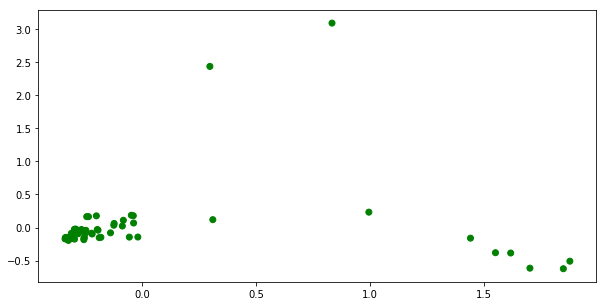

In [19]:
new_data['anomaly'] = df_result['anomaly']

plot_anomaly(new_data)

In [20]:
#predictor2.delete_endpoint()